# Higgs EFT Point by Point Likelihood Ratios

In this notebook we will show how to use approximated likelihood ratios to compute the couplings coefficients for Higgs VBF data. Likelihood is computed at various points of the parameter space and the result is interpolated using Gaussian processes for regression. The bases are computed using the code on [pyMorphWrapper](./pyMorphWrapper.py) an example of how to use the morphing code can be found [here](./Higgs EFT decomposed likelihoods.ipynb). 

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

import os, sys, inspect
cmd_folder = os.path.realpath(os.path.abspath(os.path.split(inspect.getfile( inspect.currentframe() ))[0]))
if cmd_folder not in sys.path:
    sys.path.insert(0, cmd_folder + '/carl')

In [2]:
theta = [[ 0.0230769230769, -0.253846153846 ],
         [-0.0230769230769, -0.853846153846 ],
         [ 0.0692307692308, -0.0692307692308],
         [ 0.0692307692308,  0.207692307692 ],
         [-0.115384615385,  -0.9            ],
         [-0.161538461538,   0.346153846154 ],
         [-0.207692307692,   0.0230769230769],
         [-0.207692307692,   0.669230769231 ],
         [ 0.253846153846,   0.253846153846 ],
         [-0.253846153846,  -0.3            ],
         [ 0.253846153846,   0.853846153846 ],
         [-0.346153846154,   0.9            ],
         [-0.3,              0.115384615385 ],
         [ 0.3,             -0.115384615385 ],
         [ 0.3,             -0.484615384615 ],
         [ 0.3,              0.761538461538 ],
         [-0.438461538462,  -0.484615384615 ],
         [ 0.438461538462,  -0.853846153846 ],
         [ 0.530769230769,  -0.0230769230769],
         [ 0.530769230769,   0.253846153846 ],
         [-0.530769230769,   0.3            ],
         [-0.576923076923,  -0.9            ],
         [-0.623076923077,  -0.161538461538 ],
         [-0.623076923077,   0.669230769231 ],
         [ 0.669230769231,  -0.669230769231 ],
         [ 0.761538461538,   0.392307692308 ],
         [-0.761538461538,  -0.761538461538 ],
         [ 0.761538461538,  -0.761538461538 ],
         [-0.807692307692,   0.0230769230769],
         [-0.807692307692,   0.161538461538 ]]

theta = np.array(theta)

feature_names = ["minDelR_jZ", "DelPhi_Hjj", "DelEta_Hjj", "DelPhi_jj", "DelR_jj", 
                 "DelY_jj", "Mjj", "DelPt_jj", "DelPt_ZZ", "pT_Hjj", "Mjets", "Zeppetaj3", 
                 "ZeppetaZZ", "njets","Z1_E","Z1_pt","Z1_eta","Z1_phi","Z1_m","Z2_E","Z2_pt",
                 "Z2_eta","Z2_phi","Z2_m",  "higgs_E","higgs_pt","higgs_eta","higgs_phi","higgs_m", 
                 "jet1_E","jet1_eta","jet1_y","jet1_phi","jet1_pt","jet1_m","jet2_E", "jet2_eta","jet2_y", 
                 "jet2_phi","jet2_pt","jet2_m","jet3_E","jet3_eta","jet3_y" ,"jet3_phi","jet3_pt","jet3_m"]
# subset = [33] #jet1_pt
#subset = [33, 3]
#subset = [3, 4, 6, 15, 16, 17, 18, 20, 21, 22, 23, 25, 26, 30, 33, 34, 36, 39, 40]
subset = list(range(len(feature_names)))
# Change this to you own data folder
base_dir = "/afs/cern.ch/work/j/jpavezse/public/samples_cyril/newer_samples/data/"

In [3]:
observed = 25
X_observed = np.loadtxt(base_dir + "data_%s.dat"
                        % "sm")[:25000, subset]
X_observed.shape

# ideally, X_observed should be an independent sample not used for training

(25000, 47)

In [4]:
X_num_list = []
for k in range(len(theta)):
    X_num_list.append(np.loadtxt(base_dir + "data_%d.dat" %
                                 k)[:100000, subset])

In [5]:
theta1 = 3     # arbitrary choice for theta1, should not change results
                # at least in theory...

X_den = np.loadtxt(base_dir + "data_%d.dat" % theta1)[:100000, subset]

In [6]:
from carl.ratios import ClassifierRatio
from carl.learning import CalibratedClassifierCV
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import StratifiedShuffleSplit


def make_ratio(num):
    X_num = X_num_list[num]
    X = np.vstack((X_num, X_den))
    y = np.zeros(len(X), dtype=np.int)
    y[len(X_num):] = 1

    clf = ExtraTreesClassifier(n_estimators=100, min_samples_split=20, random_state=0, n_jobs=-1)
    cv =  StratifiedShuffleSplit(n_iter=3, test_size=0.3, random_state=1)

    ratio = ClassifierRatio(
        base_estimator=CalibratedClassifierCV(clf, cv=cv, bins=20, var_width=False),
        random_state=0)
    ratio.fit(X, y)
    
    return ratio


In [ ]:
#import multiprocessing
#multiprocessing.set_start_method('forkserver')
#num_cores = multiprocessing.cpu_count()
#pool = multiprocessing.Pool(num_cores)

In [ ]:
#clf_ratios = pool.map(make_ratio, range(len(theta)))

In [7]:
llr = []
distances = []
for i in range(len(theta)):
    print(i, theta[i])
    #ratio = clf_ratios[i]
    ratio = make_ratio(i)
    llr.append(ratio.nllr(X_observed))
    print(llr[-1])


(0, array([ 0.02307692, -0.25384615]))
12.3223438894
(1, array([-0.02307692, -0.85384615]))
733.039405731
(2, array([ 0.06923077, -0.06923077]))
-10.9490531856
(3, array([ 0.06923077,  0.20769231]))
-129.387907136
(4, array([-0.11538462, -0.9       ]))
763.837891256
(5, array([-0.16153846,  0.34615385]))
55.0231822661
(6, array([-0.20769231,  0.02307692]))
20.6169835934
(7, array([-0.20769231,  0.66923077]))
549.191553763
(8, array([ 0.25384615,  0.25384615]))
33.7011422637
(9, array([-0.25384615, -0.3       ]))
79.3238375898
(10, array([ 0.25384615,  0.85384615]))
898.100482386
(11, array([-0.34615385,  0.9       ]))
1299.12506458
(12, array([-0.3       ,  0.11538462]))
66.093875219
(13, array([ 0.3       , -0.11538462]))
134.994934504
(14, array([ 0.3       , -0.48461538]))
487.459208194
(15, array([ 0.3       ,  0.76153846]))
706.460923887
(16, array([-0.43846154, -0.48461538]))
237.988221973
(17, array([ 0.43846154, -0.85384615]))
1621.13191556
(18, array([ 0.53076923, -0.02307692]

In [8]:
llr_save = np.array(llr).copy()
llr = llr_save.copy()
llr = llr[:29]
#llr = np.delete(llr, observed)
llr = np.array(llr)

In [9]:
llr *= 19.2 / len(X_observed)

In [10]:
#llr = np.loadtxt('pbyp_sm_sub2_den8.txt')
print(llr.shape)

(29,)


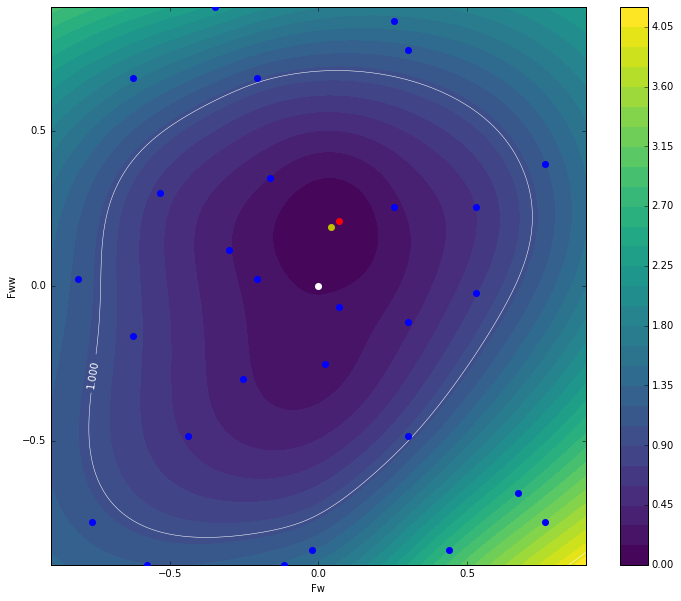

[0.76153846153799998, 0.392307692308]
[0.18937875751502997, 0.041482965931863736]


In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.mlab import griddata
plt.rcParams["figure.figsize"] = (12, 10)

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel as C, Matern

gp = GaussianProcessRegressor(alpha=0.0, normalize_y=True, 
                              kernel=C(1.0) * Matern(1.0), n_restarts_optimizer=10)
#gp.fit(np.delete(theta[:29, 1:],8,0), np.delete(llr,8))
new_theta = np.array(theta[:29])
#new_theta = np.delete(new_theta,(observed),axis=0)
gp.fit(new_theta, llr)

xi = np.linspace(-0.9, 0.9, 500)
yi = np.linspace(-0.9, 0.9, 500)
    
xx, yy = np.meshgrid(xi, yi)
zz, std = gp.predict(np.c_[xx.ravel(), yy.ravel()], return_std=True)
zi = zz.reshape(xx.shape)
std = std.reshape(xx.shape)

mle = np.unravel_index(zi.argmin(),zi.shape)
zi -= zi[mle]
zi *= 2.
#zi = zi.transpose()

cs = plt.contour(xi, yi, zi, [1.,4.,9.,16.,25.], linewidths=0.5, colors='w')
plt.clabel(cs, inline=1, fontsize=10)
cs = plt.contourf(xi, yi, zi, 30, cmap="viridis",
                  vmax=abs(zi).max(), vmin=0.0)
#plt.clim(0.,20.)

plt.colorbar()
plt.scatter(theta[:29, 0], theta[:29, 1], marker='o', c='b', s=50, lw=0, zorder=10)
plt.scatter([xi[mle[1]]], [yi[mle[0]]], marker='o', c='y', s=50, lw=0, zorder=10)
#plt.scatter([theta[observed, 0]], [theta[observed, 1]], marker='o', c='w', s=50, lw=0, zorder=10)
plt.scatter(0., 0., marker='o', c='w', s=50, lw=0, zorder=10)

plt.scatter([theta[theta1, 0]], [theta[theta1, 1]], marker='o', c='r', s=50, lw=0, zorder=10)

plt.xlim(-0.9, 0.9)
plt.ylim(-0.9, 0.9)
plt.xlabel("Fw")
plt.ylabel("Fww")
plt.show()

print([theta[observed, 0], theta[observed, 1]])
print([xi[mle[0]], yi[mle[1]]])

In [12]:
print(zz.shape)

(250000,)


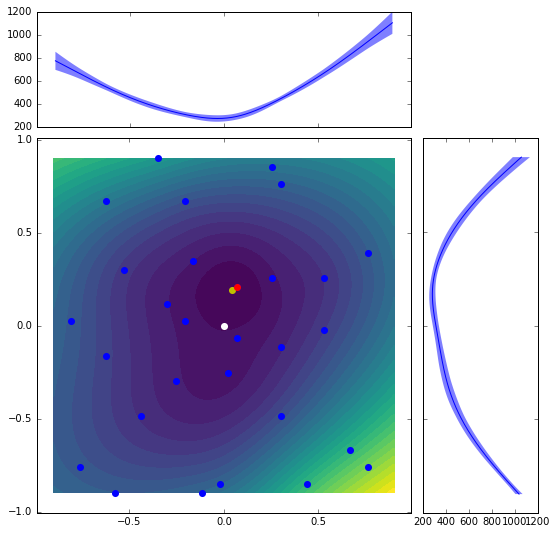

In [13]:
import matplotlib.gridspec as gridspec
from matplotlib.ticker import NullFormatter

nullfmt = NullFormatter()
# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
bottom_h = left_h = left + width + 0.02
rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom_h, width, 0.2]
rect_histy = [left_h, bottom, 0.2, height]
# start with a rectangular Figure
plt.figure(1, figsize=(8, 8))

axScatter = plt.axes(rect_scatter)
axHistx = plt.axes(rect_histx)
axHisty = plt.axes(rect_histy)

# no labels
axHistx.xaxis.set_major_formatter(nullfmt)
axHisty.yaxis.set_major_formatter(nullfmt)

axScatter.contourf(xi, yi, zi, 30, cmap="viridis",
                  vmax=abs(zi).max(), vmin=0.0)
axScatter.scatter(theta[:29, 0], theta[:29, 1], marker='o', c='b', s=50, lw=0, zorder=10)
axScatter.scatter([xi[mle[1]]], [yi[mle[0]]], marker='o', c='y', s=50, lw=0, zorder=10)
#plt.scatter([theta['observed', 0]], [theta[observed, 1]], marker='o', c='w', s=50, lw=0, zorder=10)
axScatter.scatter([theta[theta1, 0]], [theta[theta1, 1]], marker='o', c='r', s=50, lw=0, zorder=10)
axScatter.scatter(0., 0., marker='o', c='w', s=50, lw=0, zorder=10)

zx, zy = zi.sum(axis=0), zi.sum(axis=1)
stdx, stdy = std.sum(axis=0), std.sum(axis=1)
# Define size of figure

axHistx.plot(xi, zx, 'b-')
axHistx.fill(np.concatenate([xi, xi[::-1]]),
         np.concatenate([zx - 1.9600 * stdx,
                        (zx + 1.9600 * stdx)[::-1]]),
         alpha=.5, fc='b', ec='None')

axHisty.plot(zy, yi, 'b-',)
axHisty.fill(np.concatenate([zy - 1.9600 * stdy,
            (zy + 1.9600 * stdy)[::-1]]),
            np.concatenate([yi, yi[::-1]]),
            alpha=.5, fc='b', ec='None')

plt.show()


In [35]:
zi[250,250] - zi[mle]

0.028808428942056707

In [36]:
np.savetxt('pbyp_sm_{0}var_den{1}_250.txt'.format("sm",theta1), llr)

(212, 254)


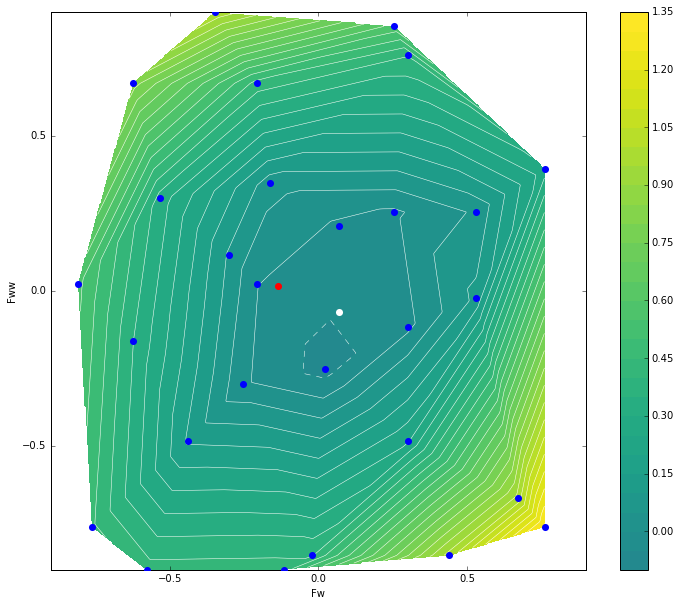

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.mlab import griddata
plt.rcParams["figure.figsize"] = (12, 10)

xi = np.linspace(-0.9, 0.9, 500)
yi = np.linspace(-0.9, 0.9, 500)
new_theta = np.array(theta[:29])
new_theta = np.delete(new_theta,(observed),axis=0)
zi = griddata(new_theta[:, 0], new_theta[:, 1], llr, xi, yi, interp='linear')
#mle = np.unravel_index(zi.argmin(),zi.shape)
print(mle)

cs = plt.contour(xi, yi, zi, 30, linewidths=0.5, colors='w')
cs = plt.contourf(xi, yi, zi, 30, cmap="viridis",
                 vmax=abs(zi).max(), vmin=-abs(zi).max())
plt.colorbar()  
plt.scatter(new_theta[:, 0], new_theta[:, 1], marker='o', c='b', s=50, lw=0, zorder=10)
plt.scatter([xi[mle[0]]], [yi[mle[1]]], marker='o', c='r', s=50, lw=0, zorder=10)
plt.scatter([theta[observed, 0]], [theta[observed, 1]], marker='o', c='w', s=50, lw=0, zorder=10)
plt.xlim(-0.9, 0.9)
plt.ylim(-0.9, 0.9)
plt.xlabel("Fw")
plt.ylabel("Fww")
plt.show()

In [55]:
np.savetxt('pbyp_sm_{0}var_den{1}.txt'.format(X_observed.shape[1],theta1), llr)